# E4 네이버 영화리뷰 감성분석 도전하기
일시: 2020년 1월 14일 목요일

# Step 1. 데이터 준비와 확인

**1. 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)를 다운받아줍니다. 해당 파일은 20만개의 리뷰로 이루어져있습니다.**

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Step 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

**2. 위 작업으로 데이터 로더를 구성합니다.**

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Step 3. 모델구성을 위한 데이터 분석 및 가공

In [5]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


**3. 데이터셋 내 문장 길이 분포를 파악합니다.** 

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


**4. 적절한 최대 문장 길이를 지정합니다.**

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


**5. ```keras.preprocessing.sequence.pad_sequences```을 활용한 패딩 추가합니다.**

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# Step 4. 모델 구성 및 validation set 구성

**6. RNN, 1-D Convolution Neural Network(1-D CNN), GlobalMaxPooling1D() 레이어 하나만 사용하는 방법을 가지고 3가지 모델을 구성합니다.**

## (1) RNN

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


## (2) 1-D Convolution Neural Network(1-D CNN)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000 
word_vector_dim = 16 

model_oned = keras.Sequential()
model_oned.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.MaxPooling1D(5))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.GlobalMaxPooling1D())
model_oned.add(keras.layers.Dense(8, activation='relu'))
model_oned.add(keras.layers.Dense(1, activation='sigmoid'))  

model_oned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [12]:
vocab_size = 10000  
word_vector_dim = 16   

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  

model_max.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**7. Training set과 validation set을 구성합니다.**

In [13]:
# validation set 30000건 분리(훈련 데이터의 총합은 약 140,000 정도)
X_val = X_train[:30000]   # 5000이나 10000으로 줄이기 줄이면 잘나옴. 
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# Step 5. 모델 훈련 개시 

**8. 구성한 3가지 모델을 각자 훈련시켜 줍니다.**

## (1) RNN

In [73]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 2s 8ms/step - loss: 0.5579 - accuracy: 0.7373 - val_loss: 0.4380 - val_accuracy: 0.8391
Epoch 2/5
227/227 [==============================] - 2s 7ms/step - loss: 0.3706 - accuracy: 0.8518 - val_loss: 0.3515 - val_accuracy: 0.8499
Epoch 3/5
227/227 [==============================] - 2s 7ms/step - loss: 0.3180 - accuracy: 0.8685 - val_loss: 0.3479 - val_accuracy: 0.8497
Epoch 4/5
227/227 [==============================] - 1s 7ms/step - loss: 0.2978 - accuracy: 0.8774 - val_loss: 0.3452 - val_accuracy: 0.8512
Epoch 5/5
227/227 [==============================] - 2s 7ms/step - loss: 0.2846 - accuracy: 0.8841 - val_loss: 0.3470 - val_accuracy: 0.8527


## (2) 1-D Convolution Neural Network(1-D CNN)

In [15]:
model_oned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history_oned = model_oned.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 7s 33ms/step - loss: 0.5101 - accuracy: 0.7269 - val_loss: 0.3530 - val_accuracy: 0.8462
Epoch 2/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3268 - accuracy: 0.8605 - val_loss: 0.3369 - val_accuracy: 0.8559
Epoch 3/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2914 - accuracy: 0.8782 - val_loss: 0.3333 - val_accuracy: 0.8571
Epoch 4/5
227/227 [==============================] - 1s 5ms/step - loss: 0.2619 - accuracy: 0.8942 - val_loss: 0.3397 - val_accuracy: 0.8560
Epoch 5/5
227/227 [==============================] - 1s 5ms/step - loss: 0.2324 - accuracy: 0.9093 - val_loss: 0.3560 - val_accuracy: 0.8533


## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [16]:
model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history_max = model_max.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 1s 5ms/step - loss: 0.5767 - accuracy: 0.7731 - val_loss: 0.4203 - val_accuracy: 0.8230
Epoch 2/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3730 - accuracy: 0.8415 - val_loss: 0.3580 - val_accuracy: 0.8426
Epoch 3/5
227/227 [==============================] - 1s 4ms/step - loss: 0.3229 - accuracy: 0.8642 - val_loss: 0.3485 - val_accuracy: 0.8483
Epoch 4/5
227/227 [==============================] - 1s 5ms/step - loss: 0.2948 - accuracy: 0.8781 - val_loss: 0.3497 - val_accuracy: 0.8497
Epoch 5/5
227/227 [==============================] - 1s 5ms/step - loss: 0.2736 - accuracy: 0.8890 - val_loss: 0.3544 - val_accuracy: 0.8492


# Step 6. Loss, Accuracy 그래프 시각화

**9. 각 모델의 성능평가를 하고, 각 결과에 대한 히스토리를 참고하여, Traing과 validation set에 대한 Loss와 Accuracy에 대한 그래프를 그립니다.    
그래프를 통해 몇 에포크까지의 트레이닝 적정한지 최적점을 추정해볼 수 있습니다.** 

## (1) RNN

In [74]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.3586 - accuracy: 0.8469
[0.35855650901794434, 0.8469393849372864]


In [75]:
history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

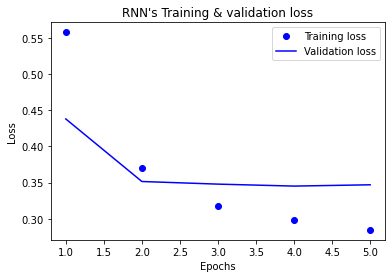

In [76]:
import matplotlib.pyplot as plt

acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

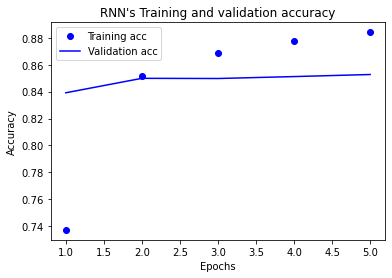

In [77]:
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (2) 1-D Convolution Neural Network(1-D CNN)

In [21]:
results_oned = model_oned.evaluate(X_test,  y_test, verbose=2)

print(results_oned)

1537/1537 - 6s - loss: 0.3692 - accuracy: 0.8494
[0.36915430426597595, 0.8494415879249573]


In [22]:
history_dict_oned = history_oned.history
print(history_dict_oned.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

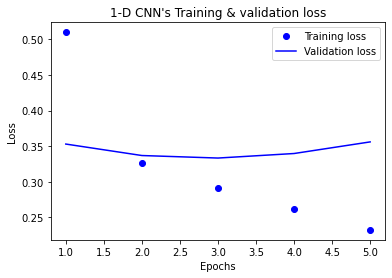

In [23]:
import matplotlib.pyplot as plt

acc_oned = history_dict_oned['accuracy']
val_acc_oned = history_dict_oned['val_accuracy']
loss_oned = history_dict_oned['loss']
val_loss_oned = history_dict_oned['val_loss']

epochs_oned = range(1, len(acc_oned) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_oned, loss_oned, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_oned, val_loss_oned, 'b', label='Validation loss')
plt.title('1-D CNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

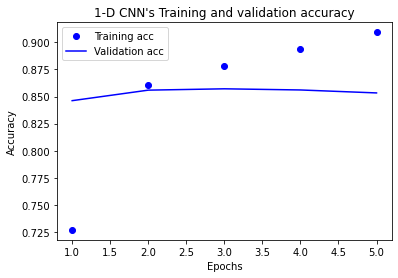

In [24]:
plt.clf()   # 그림을 초기화

plt.plot(epochs_oned, acc_oned, 'bo', label='Training acc')
plt.plot(epochs_oned, val_acc_oned, 'b', label='Validation acc')
plt.title('1-D CNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [25]:
results_max = model_max.evaluate(X_test,  y_test, verbose=2)

print(results_max)

1537/1537 - 3s - loss: 0.3648 - accuracy: 0.8437
[0.3648274838924408, 0.843704879283905]


In [26]:
history_dict_max = history_max.history
print(history_dict_max.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

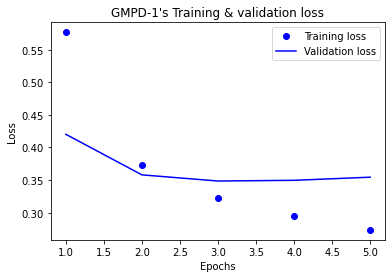

In [27]:
import matplotlib.pyplot as plt

acc_max= history_dict_max['accuracy']
val_acc_max = history_dict_max['val_accuracy']
loss_max = history_dict_max['loss']
val_loss_max = history_dict_max['val_loss']

epochs_max = range(1, len(acc_max) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_max, loss_max, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_max, val_loss_max, 'b', label='Validation loss')
plt.title('GMPD-1\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

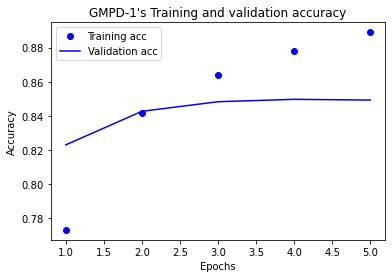

In [28]:
plt.clf()  

plt.plot(epochs_max, acc_max, 'bo', label='Training acc')
plt.plot(epochs_max, val_acc_max, 'b', label='Validation acc')
plt.title('GMPD-1\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 7. 학습된 임베딩 레이어 분석

**10. 모델에 사용한 임베딩레이어에 학습된 워드 벡터들이 의미 공간상에 유의미한 형태로 학습되었는지 각 모델별로 확인해봅니다.**

**11. 워드 벡터 파일을 저장할 디렉토리를 먼저 설치하고, 워드 벡터를 다루는데 유용한 ```gensim```패키지를 설치합니다.**

```
$ mkdir -p ~/aiffel/sentiment_classification 
$ pip install gensim
```

## (1) RNN

In [29]:
embedding_layer_rnn = model_rnn.layers[0]
weights_rnn = embedding_layer_rnn.get_weights()[0]
print(weights_rnn.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_rnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_rnn.txt'
f_rnn = open(word2vec_rnn_file_path, 'w')
f_rnn.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_rnn = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f_rnn.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_rnn[i, :])))))
f_rnn.close()

**12. ```gensim```패키지를 이용해 위에 저장해둔 임베딩 파라미터를 읽어서 word vector로 활용합니다.**

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_rnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_rnn_file_path, binary=False)
vector_rnn = word_vectors_rnn['연기']
vector_rnn

array([ 0.04987278, -0.02268951,  0.08214597, -0.03981419,  0.03378855,
       -0.08369505,  0.09043092, -0.00836625, -0.01084919,  0.01341778,
       -0.05510687,  0.02962305, -0.01031084, -0.006454  ,  0.02318836,
       -0.07505303], dtype=float32)

**13. 학습된 워드 벡터들이 의미 공간 상에 유의미하게 학습되었는지 보기 위해 단어를 하나 주고, 해당 단어와 가장 유사한 단어와 유사도를 함께 확인해봅니다.**

In [32]:
word_vectors_rnn.similar_by_word("더빙")

[('트릭', 0.8367224931716919),
 ('데미', 0.8320119380950928),
 ('스나입스', 0.8210763931274414),
 ('색히', 0.8141555786132812),
 ('헐', 0.805306077003479),
 ('판치', 0.7995924353599548),
 ('흔하', 0.7985172271728516),
 ('그런', 0.7918156385421753),
 ('헬', 0.7905849814414978),
 ('들어간', 0.7898814678192139)]

**- RNN의 경우, 유사도는 높지만 유사한 단어를 잘 찾진 못한 것 같습니다. 감성분류 태스크를 짧게 학습하여 워드 벡터가 정교하게 학습되지 않은 것 같습니다.**

**14. 나머지 모델들도 같은 작업을 반복하여 의미 공간에 워드 벡터들이 유의미하게 학습됐는지 평가해봅니다.**

## (2) 1-D Convolution Neural Network(1-D CNN)

In [33]:
embedding_layer_oned = model_oned.layers[0]
weights_oned = embedding_layer_oned.get_weights()[0]
print(weights_oned.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [34]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_oned_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_oned.txt'
f_oned = open(word2vec_oned_file_path, 'w')
f_oned.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_oned = model_oned.get_weights()[0]
for i in range(4,vocab_size):
    f_oned.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_oned[i, :])))))
f_oned.close()

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_oned = Word2VecKeyedVectors.load_word2vec_format(word2vec_oned_file_path, binary=False)
vector_oned = word_vectors_oned['연기']
vector_oned

array([-0.1119171 ,  0.03294269, -0.0168008 , -0.00829688, -0.04988557,
       -0.03821569, -0.03829876,  0.04234197,  0.0038721 , -0.03065001,
        0.01973903, -0.00892887,  0.01019919,  0.05501893, -0.00706327,
       -0.03803775], dtype=float32)

In [36]:
word_vectors_oned.similar_by_word("더빙")

[('야마카시', 0.8124159574508667),
 ('유역비', 0.7934147119522095),
 ('호구', 0.7762295007705688),
 ('스토리', 0.7714447975158691),
 ('아닌가요', 0.765021800994873),
 ('랏', 0.7622532248497009),
 ('벌이', 0.7621350288391113),
 ('살인', 0.7594096064567566),
 ('출신', 0.7552294731140137),
 ('오름', 0.7526402473449707)]

**- 출력된 단어들을 보니 역시 그닥 연관있는 단어를 찾아냈다는 생각이 들지 않습니다. 심지어 유사도도 RNN보다 전반적으로 낮습니다.**

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [37]:
embedding_layer_max = model_max.layers[0]
weights_max = embedding_layer_max.get_weights()[0]
print(weights_max.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_max_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_max.txt'
f_max = open(word2vec_max_file_path, 'w')
f_max.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_max = model_max.get_weights()[0]
for i in range(4,vocab_size):
    f_max.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_max[i, :])))))
f_max.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_max = Word2VecKeyedVectors.load_word2vec_format(word2vec_max_file_path, binary=False)
vector_max = word_vectors_max['연기']
vector_max

array([-0.08128417, -0.10058865, -0.09831261, -0.09665275, -0.00996057,
       -0.01255265, -0.08973387, -0.07247817, -0.00039152, -0.11528047,
       -0.11647761, -0.09674636, -0.11417525,  0.00826021, -0.01072743,
        0.02923498], dtype=float32)

In [40]:
word_vectors_max.similar_by_word("더빙")

[('ㅡ', 0.9199394583702087),
 ('라도', 0.9024476408958435),
 ('프로', 0.881443977355957),
 ('쟁이', 0.8677963018417358),
 ('r', 0.8648918867111206),
 ('뭐', 0.8638654947280884),
 ('격', 0.8638178110122681),
 ('큐브', 0.85687255859375),
 ('각색', 0.854587733745575),
 ('저따위', 0.8541826605796814)]

**- 1-D CNN보다 유사도는 전반적으로 높지만 사람인 제가 봤을 땐 단어의 유사성이 크게 보이지 않습니다.**

# Step 8. 한국어 word2vec 임베딩을 활용하여 성능개선

**15. 사전 학습된 한국어 word2Vec 모델을 가져와 적용해 봅니다. [한국어 word2vec](https://github.com/Kyubyong/wordvectors)에서 ```Pre-trained models```챕터로 가서 ```Korean```을 찾습니다. 2가지 선택지가 있을 텐데 ```f```을 눌러서 구글 드라이브 안으로 들어갑니다. 500MB이상의 파일을 다운받아줍니다.**      
**- 해당 한국어 word2vec은 벡터사이즈가 200이고, 코퍼스 사이즈가 339M이며, 단어 사이즈가 30185입니다.**

**16. 다운받은 파일이 다운로드에 들어가있을테니 ```sentiment_classification```디렉토리를 옮겨줍니다. 그리고 압축을 풀어줍니다.**

**17. word2vec모델을 가져와 적용해봅니다. 구글의 word2vec모델보다는 단어 수가 적으니 limit을 풀어줍니다.** 

In [41]:
from gensim.models import KeyedVectors

kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.vec'
kor_word2vec = KeyedVectors.load_word2vec_format(kor_word2vec_path, binary=False, limit=None)
kor_vector = kor_word2vec['연기']
kor_vector
print(kor_vector.shape)

(200,)


**18. 워드 벡터들끼리 의미적 유사도가 가까운지 한번 확인해봅니다. 정말 사전학습이 잘됐군요!**

In [42]:
kor_word2vec.similar_by_word("연기")

[('연기자', 0.5190777778625488),
 ('조연', 0.5179136991500854),
 ('배역', 0.5166990756988525),
 ('성우', 0.4867153763771057),
 ('주연', 0.47795748710632324),
 ('연출', 0.4733768105506897),
 ('여배우', 0.4732450544834137),
 ('각본', 0.46500182151794434),
 ('극본', 0.45965006947517395),
 ('주연상', 0.4530304968357086)]

# Step 9. 임베딩 레이어 교체

**19. 더 좋은 임베딩 레이어를 얻으니 임베링 레이어를 좋은 것으로 교체해줍니다.**

In [43]:
vocab_size = 10000    
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

**20. 위에서 구현했던 모델 3가지의 레이어를 바꿔서 다시 시도해봅니다. 모델을 구성하고 훈련하고 평가하는 과정만 그리고 그래프는 따로 도출하지 않겠습니다.**

## (1) RNN

**- 모델 구성하기**

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200

model_rnn_n = keras.Sequential()
model_rnn_n.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_rnn_n.add(keras.layers.LSTM(12))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8
model_rnn_n.add(keras.layers.Dense(8, activation='relu'))
model_rnn_n.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn_n.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 12)                10224     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 2,010,337
Trainable params: 2,010,337
Non-trainable params: 0
_________________________________________________________________


**- 모델 훈련하기**

In [70]:
model_rnn_n.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5 # 5나 3으로 고치는 것이 가장 잘 나옴

history_rnn_n = model_rnn_n.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 7s 30ms/step - loss: 0.4669 - accuracy: 0.7704 - val_loss: 0.3619 - val_accuracy: 0.8418
Epoch 2/5
227/227 [==============================] - 6s 28ms/step - loss: 0.3341 - accuracy: 0.8581 - val_loss: 0.3445 - val_accuracy: 0.8511
Epoch 3/5
227/227 [==============================] - 6s 27ms/step - loss: 0.3007 - accuracy: 0.8745 - val_loss: 0.3426 - val_accuracy: 0.8513
Epoch 4/5
227/227 [==============================] - 6s 28ms/step - loss: 0.2799 - accuracy: 0.8838 - val_loss: 0.3410 - val_accuracy: 0.8533
Epoch 5/5
227/227 [==============================] - 6s 28ms/step - loss: 0.2585 - accuracy: 0.8946 - val_loss: 0.3469 - val_accuracy: 0.8538


**- 모델 평가하기**

In [71]:
results_rnn_n = model_rnn_n.evaluate(X_test,  y_test, verbose=2)

print(results_rnn_n)

1537/1537 - 3s - loss: 0.3564 - accuracy: 0.8506
[0.356426864862442, 0.8506011366844177]


## (2) 1-D Convolution Neural Network(1-D CNN)

**- 모델 구성하기**

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = 10000 
word_vector_dim = 200

model_oned_n = keras.Sequential()
model_oned_n.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_oned_n.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned_n.add(keras.layers.MaxPooling1D(5))
model_oned_n.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned_n.add(keras.layers.GlobalMaxPooling1D())
model_oned_n.add(keras.layers.Dense(8, activation='relu'))
model_oned_n.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_oned_n.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

**- 모델 훈련하기**

In [58]:
model_oned_n.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history_oned_n = model_oned_n.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 6s 27ms/step - loss: 0.5157 - accuracy: 0.7252 - val_loss: 0.3719 - val_accuracy: 0.8344
Epoch 2/5
227/227 [==============================] - 6s 27ms/step - loss: 0.3457 - accuracy: 0.8504 - val_loss: 0.3458 - val_accuracy: 0.8493
Epoch 3/5
227/227 [==============================] - 6s 27ms/step - loss: 0.3045 - accuracy: 0.8724 - val_loss: 0.3427 - val_accuracy: 0.8526
Epoch 4/5
227/227 [==============================] - 6s 27ms/step - loss: 0.2732 - accuracy: 0.8887 - val_loss: 0.3466 - val_accuracy: 0.8521
Epoch 5/5
227/227 [==============================] - 6s 26ms/step - loss: 0.2411 - accuracy: 0.9052 - val_loss: 0.3583 - val_accuracy: 0.8513


**- 모델 평가하기**

In [59]:
results_oned_n = model_oned_n.evaluate(X_test,  y_test, verbose=2)

print(results_oned_n)

1537/1537 - 3s - loss: 0.3753 - accuracy: 0.8444
[0.3752553164958954, 0.8443965315818787]


## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

**- 모델 구성하기**

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant
 
vocab_size = 10000  
word_vector_dim = 200

model_max_n = keras.Sequential()
model_max_n.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_max_n.add(keras.layers.GlobalMaxPooling1D())
model_max_n.add(keras.layers.Dense(8, activation='relu'))
model_max_n.add(keras.layers.Dense(1, activation='sigmoid'))

model_max_n.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


**- 모델 학습하기**

In [61]:
model_max_n.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history_max_n = model_max_n.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 6s 27ms/step - loss: 0.6594 - accuracy: 0.6314 - val_loss: 0.5792 - val_accuracy: 0.7303
Epoch 2/5
227/227 [==============================] - 6s 25ms/step - loss: 0.5115 - accuracy: 0.7716 - val_loss: 0.4656 - val_accuracy: 0.7851
Epoch 3/5
227/227 [==============================] - 6s 25ms/step - loss: 0.4130 - accuracy: 0.8171 - val_loss: 0.4090 - val_accuracy: 0.8110
Epoch 4/5
227/227 [==============================] - 6s 25ms/step - loss: 0.3613 - accuracy: 0.8424 - val_loss: 0.3902 - val_accuracy: 0.8223
Epoch 5/5
227/227 [==============================] - 6s 25ms/step - loss: 0.3304 - accuracy: 0.8594 - val_loss: 0.3806 - val_accuracy: 0.8288


**- 모델 평가하기**

In [62]:
results_max_n = model_max_n.evaluate(X_test,  y_test, verbose=2)

print(results_max_n)

1537/1537 - 2s - loss: 0.3875 - accuracy: 0.8253
[0.3874897062778473, 0.8252944350242615]


# 루브릭

1. RNN과 CNN, MaxPooling Layer하나만 사용하는 모델 등의 3가지 모델의 이용해서 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였습니다.

2. gensim을 통해 유사단어 찾기를 활용했습니다. 자체학습한 임베딩과 사전학습된 임베딩 레이어를 모두 분석했습니다.

3. 한국어 Word2Vec를 활용하여 네이버 영화리뷰 데이터 감성분석 모델 3가지 중 RNN의 정확도를 85%이상 달성했습니다. 한국어 Word2Vec를 사용하기 전에는 정확도가 84.69였다면 사용하고 나서는 85.06이 되었습니다.

# 회고 

가장 오래 붙잡고 있었는 프로젝트였습니다. 오래 잡고 있다고 해서 몇날 며칠 밤을 고민했다는 얘기로 들리시겠지만 사실 매일 하진 않았습니다. 주말에는 놀고싶어서 놀고 주중에도 보기 싫어서 보지 않은 날도 있었기 때문이죠. 어느덧 제출기한이 6시간 정도 남은 때가 되었습니다. 오늘부로 이 아이를 85%의 정확도를 찍고 놓아줄 수 있어서 너무나 기쁩니다.

처음하는 자연어처리 관련 프로젝트였습니다. 저는 언어학을 조금 배운 적이 있어서 자연어 처리 쪽에 흥미가 있었습니다. 아니 사실은 없는데 흥미가 있다고 스스로한테 자기 최면을 건 것일 수 있습니다. 그래서 프로젝트를 하기 전에는 '이 프로젝트만 하면 내가 자연어 처리와 맞는지 아닌지 알 수 있겠다!'라는 생각을 했었습니다. 그런데 하고보니 (개뿔...) 아직도 잘 모르겠습니다. 이번 프로젝트를 완전히 이해하지 못하기도 했고, 노드에서 대부분 긁어왔고, 딱히 '우와 엄청나게 재밌다!'라는 생각도 들진 않았습니다. 컴퓨터 비전 쪽이 더 재밌는 것 같습니다. 음... 솔직히 아직 하나해보고 얘기하긴 좀 이르겠죠?    

그래도 수확이 있었습니다. 나날이 발전함을 느끼고 있습니다. cs231n에서 조금, 코딩마스터에서 조금, 조에서 얘기하면서 조금, 스터디하면서 조금씩 얻었던 지식들 덕분에 모델 코드를 보면 좀 이해가 되기 시작했습니다. 한 달 만에 이렇게 변했다니 자신이 좀 기특하게 느껴집니다. 하하!